# Meta-Training SNNs using MAML

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from collections import OrderedDict

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse
from torchviz import make_dot
from tqdm.notebook import tqdm, trange

In [2]:
from tqdm.notebook import trange

In [3]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [4]:
from eventprop.config import get_flat_dict_from_nested

In [5]:
data_config = {
    "seed": 42,
    "dataset": "randman",
    "deterministic": True,
    "meta_batch_size": 1,
    "encoding": "latency",
    "T": 30,
    "dt": 1e-3,
    "t_min": 0,
    "t_max": 2,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,  # adaptation steps
    "n_tasks_per_split_train": 100,  # number of rotations
    "n_tasks_per_split_test": 20,  # number of rotations
    "n_tasks_per_split_val": 20,  # number of rotations
    "dataset_size": 1000,  # testing size
}
data_args = argparse.Namespace(**data_config)

In [6]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
torch.cuda.is_available()

False

In [8]:
from eventprop.training import encode_data
from torchmeta.transforms import ClassSplitter

encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])

dataset_split = lambda d: ClassSplitter(
    d,
    num_train_per_class=data_config["dataset_size"],
    num_test_per_class=data_config["dataset_size"],
    shuffle=True,
)

## Randman Data

In [9]:
from randman.torch_randman import RandmanDataset

In [69]:
randman_config = {
    "nb_classes": 3,
    "nb_units": 5,
    "nb_steps": data_config["T"],
    "dim_manifold": 1,
    "nb_spikes": 1,
    "shuffle": True,
}

data_config.update(randman_config)


In [70]:
from randman.meta import get_all_datasets

In [71]:
(
    (
        meta_train_dataset,
        meta_val_dataset,
        meta_test_dataset,
    ),
    (
        meta_train_dataloader,
        meta_val_dataloader,
        meta_test_dataloader,
    ),
) = get_all_datasets(
    data_config, randman_config, dataset_split=dataset_split, encode_tranform=None
)

In [72]:
spikes, targets = next(iter(meta_test_dataloader))["train"]
spikes = spikes.argmax(-2).squeeze()

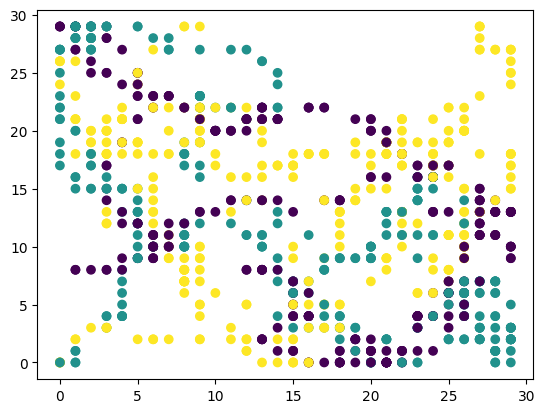

In [73]:
plt.scatter(spikes[:, 0], spikes[:, 1], c=targets)

## Rotation Ying Yang data for Meta Learning

In [15]:
from yingyang.meta_dataset import YingYangMetaDataset
from torchmeta.utils.data import BatchMetaDataLoader


In [16]:
meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_train=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_val=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_test=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)

meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["meta_batch_size"],
    shuffle=True,
    num_workers=0,
)

meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

In [17]:
len(meta_train_dataset)

100

In [18]:
next(iter(meta_train_dataloader))["train"][0].shape

torch.Size([1, 1000, 4])

In [27]:
training_batch = next(iter(meta_train_dataloader))
testing_batch = next(iter(meta_test_dataloader))

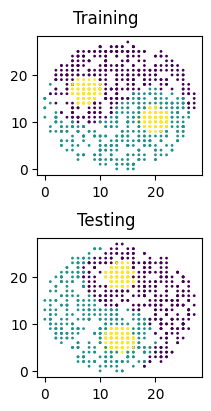

In [28]:
fig = plt.figure(figsize=(2 * data_config["meta_batch_size"], 4), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for batch, subfig in zip([training_batch, testing_batch], subfigs):
    axs = subfig.subplots(1, data_config["meta_batch_size"])
    for i, (x, y) in enumerate(zip(*batch["train"])):
        try:
            ax = axs[i]
        except TypeError:
            ax = axs
        ax.scatter(
            x.argmax(1).squeeze()[:, 0], x.argmax(1).squeeze()[:, 1], c=y, cmap="viridis", s=1
        )
    subfig.suptitle("Training" if batch is training_batch else "Testing")

## Models

In [15]:
from eventprop.models import SNN, SpikeCELoss, FirstSpikeTime

In [74]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale_0_mu": 5,
        "scale_0_sigma": 3.5,
        "scale_1_mu": 5,
        "scale_1_sigma": 0.5,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    # "device": (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
    "device": torch.device("cpu"),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4, "randman": 5}
n_outs = {"mnist": 10, "ying_yang": 3, "randman": randman_config["nb_classes"]}

In [75]:
loss_config = {
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
}

inner_optim_config = {
    "optimizer": "adam",
    "lr": 1e-2,
    "weight_decay": 0.0,
    # "gamma": 0.95,
    "beta_1": 0.9,
    "beta_2": 0.99,
}

outer_optim_config = {"step_size": 2e-3, "annealing": "linear"}

meta_config = {
    "n_epochs": 100,
    "num_shots": 25,
    "n_samples_test": 1000,
    "first_order": True,
    "learn_step_size": False,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "inner_optim": inner_optim_config,
    "outer_optim": outer_optim_config,
    "meta": meta_config,
    "loss": loss_config,
}

config = get_flat_dict_from_nested(default_config)
args = argparse.Namespace(**config)

In [76]:
config["alpha"]

0.003

In [77]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

# model = SNN(dims, **config).to(config["device"])
# init_params = OrderedDict(model.meta_named_parameters()).copy()
# loss_fn = SpikeCELoss(**config)

In [152]:
raise KeyboardInterrupt

KeyboardInterrupt: 

## REPTILE

In [ ]:
from eventprop.meta import REPTILE

reptile_trainer = REPTILE(model, flat_config=config)

In [ ]:
train_accs = {
    "pre": [],
    "post": [],
}

test_accs = {
    "pre": [],
    "post": [],
}

all_accs = {
    "train": train_accs,
    "test": test_accs,
}

In [ ]:
for ep in trange(10, position=0, desc="Epochs"):

    for trial, accs in all_accs.items():
        for acc in accs.values():
            acc.append([])

    for training_batch in meta_train_dataloader:
        outer_loss, results = reptile_trainer.get_outer_loss(
            training_batch, use_tqdm=True, train=True, position=1
        )
        train_accs["pre"][-1].append([results["meta_accs"]["pre"]])
        train_accs["post"][-1].append([results["meta_accs"]["post"]])

    for testing_batch in meta_test_dataloader:
        outer_loss, results = reptile_trainer.get_outer_loss(
            testing_batch, use_tqdm=False, train=False
        )
        test_accs["pre"][-1].append([results["meta_accs"]["pre"]])
        test_accs["post"][-1].append([results["meta_accs"]["post"]])

0.0019950000000000002
0.001994
0.001993
0.001992
0.001991
0.00199
0.0019890000000000003
0.001988
0.001987
0.001986
0.0019850000000000002
0.001984
0.001983


In [ ]:
train_accs = {k: np.array([np.mean(a) for a in accs]) for k, accs in train_accs.items()}

/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
train_accs["post"]

array([       nan, 0.41049996,        nan, 0.38296667, 0.3971    ,
       0.39932501, 0.40482497, 0.40469998, 0.40599999, 0.41494998,
       0.42189997, 0.42052498, 0.42642504, 0.40154997, 0.41685   ])

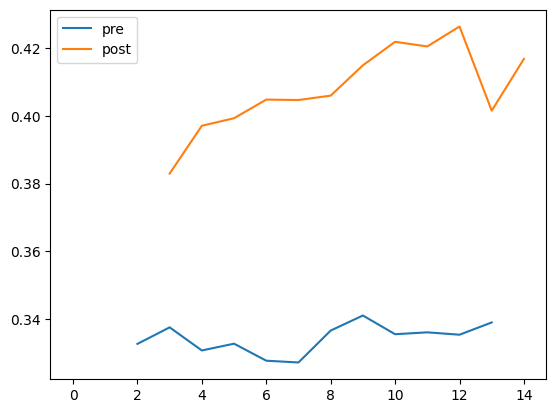

In [ ]:
plt.plot(train_accs["pre"], label="pre")
plt.plot(train_accs["post"], label="post")
plt.legend()

In [ ]:
(
    training_batch["train"][1].float().mean(0)[None, :] == training_batch["train"][1].float()
).float().mean()

tensor(0.0424)

In [ ]:
import torchviz

In [ ]:
torchviz.make_dot(outer_loss, dict(model.named_parameters())).render("maml_loss")

'maml_loss.pdf'

## MAML

In [78]:
from eventprop.meta import MAML
import wandb

In [79]:
outer_optim_config = {"meta_lr": 1e-2}

meta_config = {
    "n_epochs": 100,
    "num_shots": 10,
    "n_samples_test": 1000,
    "first_order": True,
    "learn_step_size": False,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "inner_optim": inner_optim_config,
    "outer_optim": outer_optim_config,
    "meta": meta_config,
    "loss": loss_config,
}

use_best_sweep_params = True
sweep_id = "804krio6"
best_params_to_use = {"inner_optim", "model", "loss"}

config = get_flat_dict_from_nested(default_config)

if use_best_sweep_params:
    api = wandb.Api()
    sweep_path = f"m2snn/eventprop/{sweep_id}"
    sweep = api.sweep(sweep_path)
    best_run = sweep.best_run()
    best_params = best_run.config

if use_best_sweep_params and best_params_to_use is not None:
    best_params = {
        k: best_params.get(k, None)
        for k in get_flat_dict_from_nested({k: default_config[k] for k in best_params_to_use})
    }

    if "seed" in best_params:
        best_params.pop("seed")
    if "device" in best_params:
        best_params.pop("device")
    print("Overriding config with:", best_params)

if use_best_sweep_params:
    config.update(best_params, allow_val_change=True)

wandb: Sorting runs by -summary_metrics.mean_test_acc


Overriding config with: {'model_type': 'eventprop', 'T': 30, 'dt': 0.001, 'tau_m': 0.02, 'tau_s': 0.005, 'init_mode': 'kaiming_both', 'scale_0_mu': 3.5, 'scale_0_sigma': 5.7, 'scale_1_mu': 3.5, 'scale_1_sigma': 5.4, 'n_hid': 120, 'resolve_silent': False, 'dropout': 0, 'optimizer': 'adam', 'lr': 0.0362, 'weight_decay': 0, 'beta_1': 0.9, 'beta_2': 0.898, 'loss': 'ce_temporal', 'alpha': 0.0158, 'xi': 1.61, 'beta': 57}


In [80]:
model = SNN(dims, **config).to(config["device"])
maml_trainer = MAML(model, config)
training_batch = next(iter(meta_train_dataloader))

In [ ]:
all_results = []
pbar = tqdm(range(1000))
for _ in pbar:
    outer_loss, results = maml_trainer.get_outer_loss(training_batch, train=True)
    pbar.set_postfix(results[1])
    all_results.append(results)

In [162]:
post_accs = np.array([r[1]["post"] for r in all_results]).squeeze()
pre_accs = np.array([r[1]["pre"] for r in all_results]).squeeze()
plt.plot(np.convolve(post_accs, np.ones(10) / 10, mode="valid"), label="post")
plt.plot(np.convolve(pre_accs, np.ones(10) / 10, mode="valid"), label="pre")
plt.legend()

ValueError: v cannot be empty

In [47]:
np.array([r[1]["post"] for r in all_results]).shape

(100, 1)

In [33]:
results

({'pre': [1.0638985633850098], 'post': [0.7440981864929199]},
 {'pre': [tensor(0.3380)], 'post': [tensor(0.5780)]})

### GIF

In [ ]:
import torchopt
import torch.nn.functional as F
from eventprop.meta import create_gif

In [ ]:
train_sample, test_sample = [d[0] for d in training_batch["train"]], [
    d[0] for d in training_batch["test"]
]

create_gif(
    maml_trainer, train_sample, test_sample)

Adaptation:   1%|          | 1/100 [00:00<00:20,  4.72it/s]

: 

## iMAML

In [ ]:
import torchopt
from torchopt.diff.implicit import ImplicitMetaGradientModule
from torchopt.visual import make_dot
from torchviz import make_dot as make_dot2

In [ ]:
class InnerNet(
    ImplicitMetaGradientModule,
    linear_solve=torchopt.linear_solve.solve_normal_cg(maxiter=5, atol=0),
):
    def __init__(self, meta_net, loss_fn, n_inner_iter, reg_param, optim_params):
        super().__init__()
        self.loss_fn = loss_fn
        self.meta_net = meta_net
        self.net = torchopt.module_clone(meta_net, by="deepcopy", detach_buffers=True)
        self.n_inner_iter = n_inner_iter
        self.reg_param = reg_param
        self.reset_parameters()
        self.optim_params = optim_params

    def reset_parameters(self):
        with torch.no_grad():
            for p1, p2 in zip(self.parameters(), self.meta_parameters()):
                p1.data.copy_(p2.data)
                p1.detach_().requires_grad_()

    def forward(self, x):
        if len(x.shape) > 3:
            x = x.transpose(0, 1).squeeze()
        return self.net(x)

    def objective(self, x, y):
        # single sample processing
        out, _ = self(x)
        loss = self.loss_fn(out, y)[0]
        regularization_loss = 0
        for p1, p2 in zip(self.parameters(), self.meta_parameters()):
            regularization_loss += 0.5 * self.reg_param * torch.sum(torch.square(p1 - p2))
        return loss + regularization_loss

    def adapt(self, inputs, targets):
        # Adaptation fn
        params = tuple(self.parameters())
        inner_optim = torchopt.Adam(params, lr=self.optim_params["lr"])
        with torch.enable_grad():
            # Temporarily enable gradient computation for conducting the optimization
            for x, y, _ in zip(inputs, targets, range(self.n_inner_iter)):
                loss = self.objective(x, y)
                inner_optim.zero_grad()
                loss.backward(inputs=params)
                inner_optim.step()

        return self

    def solve(self, input, target):
        return self.adapt(input, target)

In [ ]:
inner_net = InnerNet(model, loss_fn, 10, 0, inner_optim_config)

In [ ]:
import time


def train(data_loader, net, meta_opt, epoch, log, loss_fn):

    n_inner_iter = config["n_samples_per_task"]
    reg_param = 2
    task_num = len(data_loader.dataset)
    n_train_iter = len(data_loader)
    i = 0

    inner_nets = [InnerNet(net, n_inner_iter, reg_param) for _ in range(task_num)]
    for batch_idx, training_batch in enumerate(data_loader):
        start_time = time.time()
        # Sample a batch of support and query images and labels.
        x_train, y_train, x_test, y_test = *training_batch["train"], *training_batch["test"]

        test_losses = []
        test_accs = []
        meta_opt.zero_grad()

        for i in range(task_num):
            # Optimize the likelihood of the support set by taking
            # gradient steps w.r.t. the model's parameters.
            # This adapts the model's meta-parameters to the task.

            inner_net = inner_nets[i]
            inner_net.reset_parameters()
            optimal_inner_net = inner_net.solve(x_train[i], y_train[i])

            # The final set of adapted parameters will induce some
            # final loss and accuracy on the query dataset.
            # These will be used to update the model's meta-parameters.

            out_spikes, _ = optimal_inner_net(x_test[i])
            test_loss, _, first_spikes = loss_fn(out_spikes, y_test[i])
            test_acc = (first_spikes.argmin(dim=-1) == y_test[i]).float().mean()
            test_losses.append(test_loss)
            test_accs.append(test_acc.item())

        test_losses = torch.mean(torch.stack(test_losses))
        test_losses.backward()
        meta_opt.step()
        test_losses = test_losses.item()
        test_accs = 100.0 * np.mean(test_accs)
        i = epoch + float(batch_idx) / n_train_iter
        iter_time = time.time() - start_time

        print(
            f"[Epoch {i:.2f}] Train Loss: {test_losses:.2f} | Acc: {test_accs:.2f} | Time: {iter_time:.2f}",
        )
        # log.append(
        #     {
        #         'epoch': i,
        #         'loss': qry_losses,
        #         'acc': qry_accs,
        #         'mode': 'train',
        #         'time': time.time(),
        #     },
        # )


def test(db, net, epoch, log, args):
    # Crucially in our testing procedure here, we do *not* fine-tune
    # the model during testing for simplicity.
    # Most research papers using MAML for this task do an extra
    # stage of fine-tuning here that should be added if you are
    # adapting this code for research.
    n_test_iter = db.x_test.shape[0] // db.batchsz

    qry_losses = []
    qry_accs = []

    # TODO: Maybe pull this out into a separate module so it
    # doesn't have to be duplicated between `train` and `test`?
    n_inner_iter = args.inner_steps
    reg_param = args.reg_params

    for _ in range(n_test_iter):
        x_spt, y_spt, x_qry, y_qry = db.next("test")

        task_num = x_spt.size(0)

        for i in range(task_num):
            # Optimize the likelihood of the support set by taking
            # gradient steps w.r.t. the model's parameters.
            # This adapts the model's meta-parameters to the task.

            inner_net = InnerNet(net, n_inner_iter, reg_param)
            with torch.no_grad():
                optimal_inner_net = inner_net.solve(x_spt[i], y_spt[i])

            # The query loss and acc induced by these parameters.
            qry_logits = optimal_inner_net(x_qry[i])
            qry_loss = F.cross_entropy(qry_logits, y_qry[i])
            qry_acc = (qry_logits.argmax(dim=1) == y_qry[i]).float().mean()
            qry_losses.append(qry_loss.item())
            qry_accs.append(qry_acc.item())

    qry_losses = np.mean(qry_losses)
    qry_accs = 100.0 * np.mean(qry_accs)

    print(f"[Epoch {epoch+1:.2f}] Test Loss: {qry_losses:.2f} | Acc: {qry_accs:.2f}")
    log.append(
        {
            "epoch": epoch + 1,
            "loss": qry_losses,
            "acc": qry_accs,
            "mode": "test",
            "time": time.time(),
        },
    )

In [ ]:
meta_sample_train, meta_sample_test = training_batch["train"], training_batch["test"]
meta_sample_train = [d[0][:10] for d in meta_sample_train]
meta_sample_test = [d[0][:10] for d in meta_sample_test]
inner_net.reset_parameters()

In [ ]:
optimal_inner_net = inner_net.solve(*meta_sample_train)

RuntimeError: Class values must be smaller than num_classes.

In [ ]:
out_spikes, _ = optimal_inner_net(meta_sample_test[0])
test_loss, _, first_spikes = loss_fn(out_spikes, meta_sample_test[1])
test_acc = (first_spikes.argmin(dim=-1) == meta_sample_test[1]).float().mean()
test_acc

tensor(0.4000)

In [ ]:
make_dot(test_loss, dict(model.named_parameters())).render("test_loss")

'test_loss.pdf'

In [ ]:
meta_opt = torchopt.Adam(model.parameters(), lr=1e-3)

In [ ]:
with torch.autograd.set_detect_anomaly(True):
    test_loss.backward(inputs=tuple(model.parameters()))

/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/torch/_functorch/deprecated.py:73: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vjp is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.vjp instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vjp')
/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/si

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [10, 3, 1]], which is output 0 of AsStridedBackward0, is at version 49; expected version 48 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
for n, p in optimal_inner_net.named_parameters():
    print(n, p.grad)

net.layers.0.weight None
net.layers.1.weight None


/tmp/ipykernel_4386/1039979153.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608983249/work/build/aten/src/ATen/core/TensorBody.h:489.)
  print(n, p.grad)


In [ ]:
x_train.shape

torch.Size([1, 1000, 50, 1, 5])

In [ ]:
len(meta_train_dataloader.dataset)

20

In [ ]:
meta_sample = [d[0] for d in training_batch["train"]]

In [ ]:
inner_net.solve(meta_sample[0], meta_sample[1])

InnerNet(
  (net): SNN(
    (layers): RecordingSequential(
      (0): SpikingLinear_ev(5, 120)
      (1): SpikingLinear_ev(120, 3)
    )
  )
)

In [ ]:
meta_sample[1].shape

torch.Size([1000])

In [ ]:
meta_sample[0].transpose(0, 1).squeeze().shape

torch.Size([50, 1000, 5])

## DEBUGGING / PROPTOTYPE

### Finding the joint-training baseline (training on all rotations at once)

In [ ]:
model = SNN(dims, **config).to(config["device"])
inner_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
maml_trainer = MAML(model, default_config)
maml_trainer.inner_optimizer = inner_optimizer

SNN SCALE :  [[5, 3.5], [5, 0.5]]


In [ ]:
batch_size = 512
inputs = (
    training_batch["train"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
)
random_idxs = torch.randperm(inputs.shape[0])
targets = training_batch["train"][1].flatten()
inputs, targets = inputs[random_idxs], targets[random_idxs]

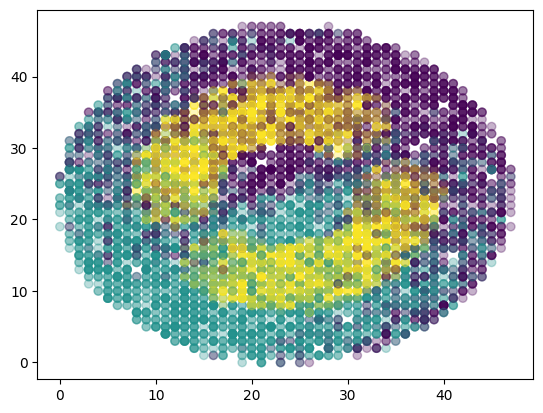

In [ ]:
plt.scatter(inputs.argmax(1)[:, 0, 0], inputs.argmax(1)[:, 0, 1], c=targets[:], alpha=0.3)

In [ ]:
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    maml_trainer.adapt((input, target))

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
test_accs = []
inputs = training_batch["test"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
targets = training_batch["test"][1].flatten()
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    acc, *_ = maml_trainer.inner_test((input, target))
    test_accs.append(acc)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
np.mean(test_accs)

0.44818473

### Making sure we can overfit on one subtask

In [ ]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets))
print(f"Pre Adaptation Accuracy: {acc}")

Pre Adaptation Accuracy: 0.5120000243186951


In [ ]:
inputs, targets = training_batch["train"]
inputs = inputs[0]
targets = targets[0].to(config["device"])
new_params = maml_trainer.adapt((inputs, targets), use_tqdm=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets), new_params)
print(f"Post Adaptation Accuracy: {acc}")

Post Adaptation Accuracy: 0.5120000243186951


## Outer Loss